In [1]:
import numpy as np
import pandas as pd
import sys, os, glob
import matplotlib.pyplot as plt
from jaxstar.utils import *

In [2]:
import seaborn as sns
sns.set(style='ticks', font_scale=1.6, font='sans-serif')
from matplotlib import rc
rc('text', usetex=True)
%matplotlib inline

In [3]:
obskeys = ['teff', 'feh', 'logg', 'kmag', 'parallax']
keys = ['age', 'mass', 'radius'] + obskeys

def summary_stats(postdir, names, keys, stat='pct', **kwargs):
    if stat=='pct':
        summary = summary_pct
    else:
        summary = summary_hdi

    dout = pd.DataFrame({})
    for i,name in enumerate(names):
        filename = postdir + str(name) + '_samples.csv'
        if not os.path.exists(filename):
            print ("# output for %s does not exist."%name)
            continue
        dp = pd.read_csv(filename)
        _dic = {"name": name}
        for k in keys:
            _k = 'iso_' + k
            _dic[_k], _dic[_k+"_upp"], _dic[_k+"_low"] = summary(np.array(dp[k]), **kwargs)
        dout = dout.append([_dic])

    return dout.reset_index(drop=True)

def summarize_results(postdir, dinput, keys, stat='pct'):
    d = summary_stats(postdir, dinput.kepid, keys, stat=stat).rename({"name": "kepid"}, axis='columns')
    d = pd.merge(d, dinput[["kepid"]+obskeys+[_k+"_err" for _k in obskeys]], on='kepid')
    for key in obskeys:
        d["d"+key] = d["iso_"+key] - d[key]
        d["dsigma"+key] = d["d"+key] / d[key+"_err"]
    return d


In [4]:
dast = pd.read_csv("dast.csv")

In [5]:
dinput = pd.read_csv("../input/isoinput_hall.csv")
dinput["kmag"] = dinput.kmag_corrected
dinput["kmag_err"] = dinput.kmag_err_corrected
dinput["parallax"] = dinput.parallax_corrected
dinput["parallax_err"] = dinput.parallax_error_corrected
dinput["teff_err"] = 110
dinput["feh_err"] = 0.1
dinput["logg_err"] = 0.1

In [6]:
postdir = "../posterior_samples/posteriors_hall_linage/"
dpct = summarize_results(postdir, dinput, keys)
dhdi = summarize_results(postdir, dinput, keys, stat='hdi')
postdir = "../posterior_samples/posteriors_hall_logage/"
dpct_log = summarize_results(postdir, dinput, keys)
dhdi_log = summarize_results(postdir, dinput, keys, stat='hdi')

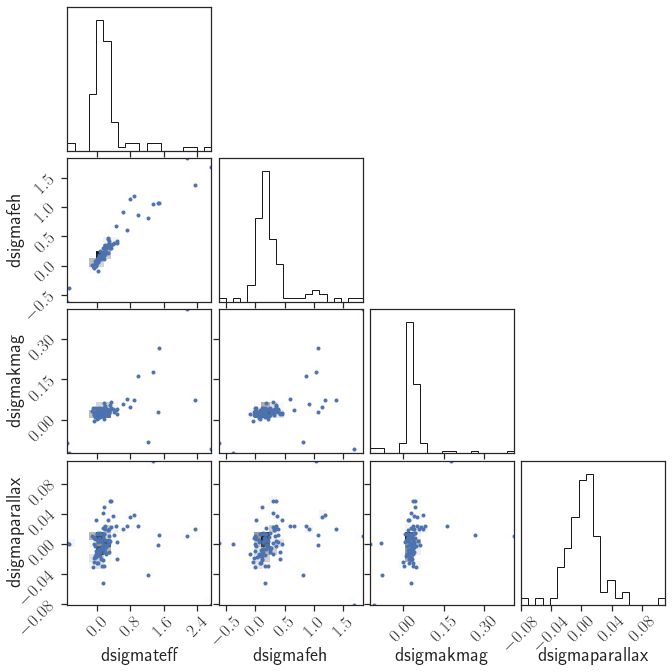

In [8]:
import corner
fig = corner.corner(dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]], plot_contours=False)
fig = corner.overplot_points(fig, dpct[["dsigmateff", "dsigmafeh", "dsigmakmag", "dsigmaparallax"]])

In [9]:
labels = ["pct_lin", "hdi_lin", "pct_log", "hdi_log"]
data = []
for _d in [dpct, dhdi, dpct_log, dhdi_log]:
    data.append(pd.merge(dast, _d, on='kepid'))

In [10]:
for d,l in zip(data, labels):
    idxbad = (d.iso_age - d.Age) > 4
    d["dsigma"] = np.sqrt(d.dsigmateff**2 + d.dsigmafeh**2)
    print (l)
    print (d[idxbad][['kepid', 'dsigmateff',  'dsigmafeh', 'feh', 'dsigma']])

pct_lin
      kepid  dsigmateff  dsigmafeh   feh    dsigma
19  7106245    1.453260   1.071763 -0.99  1.805724
32  8379927    0.187994   0.269859 -0.10  0.328885
38  9025370    2.752899   1.680982 -0.12  3.225547
48  9965715    0.250017   0.218611 -0.44  0.332113
hdi_lin
      kepid  dsigmateff  dsigmafeh   feh    dsigma
19  7106245    1.489936   0.692572 -0.99  1.643036
38  9025370    2.598214   1.550603 -0.12  3.025737
48  9965715    0.358480   0.217757 -0.44  0.419435
pct_log
      kepid  dsigmateff  dsigmafeh   feh    dsigma
19  7106245    1.484118   1.065266 -0.99  1.826855
38  9025370    2.766534   1.703099 -0.12  3.248731
48  9965715    0.372927   0.303598 -0.44  0.480881
hdi_log
      kepid  dsigmateff  dsigmafeh   feh    dsigma
19  7106245    1.470780   0.955287 -0.99  1.753786
38  9025370    2.709475   1.716602 -0.12  3.207488
48  9965715    0.484884   0.158355 -0.44  0.510087


In [34]:
mlabel = 'seismic mass ($M_\odot$)'
alabel = 'seismic age (Gyr)'
mylabel = 'isochrone $-$ seismic mass ($M_\odot$)'
aylabel = 'isochrone $-$ seismic age (Gyr)'

def plot(d, figname, mth=1.3):
    ms = 5
    fig, ax = plt.subplots(2,2,figsize=(14*1.2,8*1.), sharex='col', sharey='row')

    xkey, astkey, isokey = 'Mass', 'Mass', 'iso_mass'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[0,0].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='o', lw=1, markersize=ms,
    label='mass difference: $%.2f\pm%.2f\,M_\odot$'%(np.mean(dy), np.std(dy)))
    ax[0,0].set_ylabel(mylabel)

    xkey, astkey, isokey = 'Mass', 'Age', 'iso_age'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[1,0].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='o', lw=1, markersize=ms,
    label='logage difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    ax[1,0].set_ylabel(aylabel)
    ax[1,0].set_xlabel(mlabel)

    xkey, astkey, isokey = 'Age', 'Mass', 'iso_mass'
    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[0,1].errorbar(d[idx][xkey][idxm], d[idx][isokey][idxm] - d[idx][astkey][idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, markersize=ms, alpha=1.,label='mass difference: $%.2f\pm%.2f\,M_\odot$'%(np.mean(dy), np.std(dy)))
    idxm = d.Mass>mth
    ax[0,1].errorbar(d[idx][xkey][idxm], (d[idx][isokey] - d[idx][astkey])[idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]],  fmt='o', lw=1, color='C0', alpha=0.3)

    xkey, astkey, isokey = 'Age', 'Age', 'iso_age'
    """
    dy = d[idx][isokey] - d[idx][astkey]
    ax[1,1].errorbar(d[idx][xkey], d[idx][isokey] - d[idx][astkey], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"], d[idx][isokey+"_upp"]], fmt='.', marker='o', lw=1, markersize=ms,
    label='age difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    """

    dy = d[idx][isokey] - d[idx][astkey]
    idxm = d.Mass<mth
    ax[1,1].errorbar(d[idx][xkey][idxm], d[idx][isokey][idxm] - d[idx][astkey][idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, markersize=ms, alpha=1.,
    label='age difference: $%.2f\pm%.2f\,\mathrm{Gyr}$'%(np.mean(dy), np.std(dy)))
    idxm = d.Mass>mth
    ax[1,1].errorbar(d[idx][xkey][idxm], (d[idx][isokey] - d[idx][astkey])[idxm], #xerr=[d[idx]["e_"+xkey], d[idx]["E_"+xkey]],
    yerr=[d[idx][isokey+"_low"][idxm], d[idx][isokey+"_upp"][idxm]], fmt='o', lw=1, color='C0', alpha=0.3)
    ax[1,1].set_xlabel(alabel)

    ax[0,1].legend(loc='upper right')
    ax[1,1].legend(loc='upper right')
    #ax[0,1].set_ylim(-0.33,0.33)
    #ax[1,1].set_ylim(-5, 5)

    for _ax in ax[0]:
        _ax.axhline(y=0, color='gray', alpha=0.5)
    for _ax in ax[1]:
        _ax.axhline(y=0, color='gray', alpha=0.5)

    ax[0,0].yaxis.set_label_coords(-0.075, 0.5)
    ax[1,0].yaxis.set_label_coords(-0.075, 0.5)
    fig.tight_layout(pad=0.15)
    plt.savefig(figname, dpi=200, bbox_inches="tight", facecolor='white')

pct_lin
hdi_lin
pct_log
hdi_log


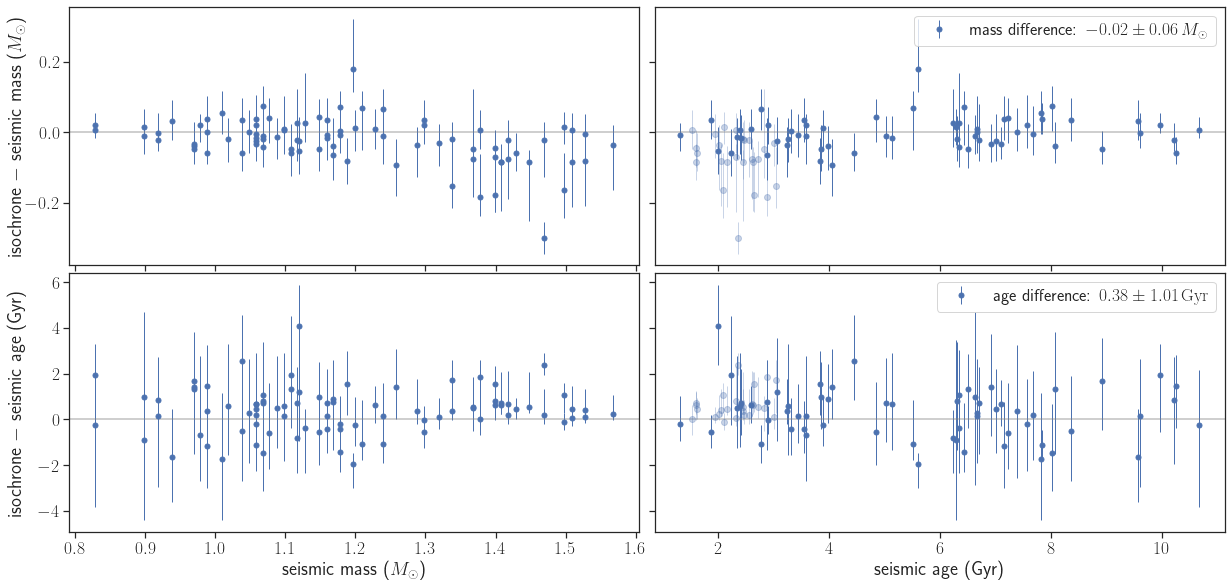

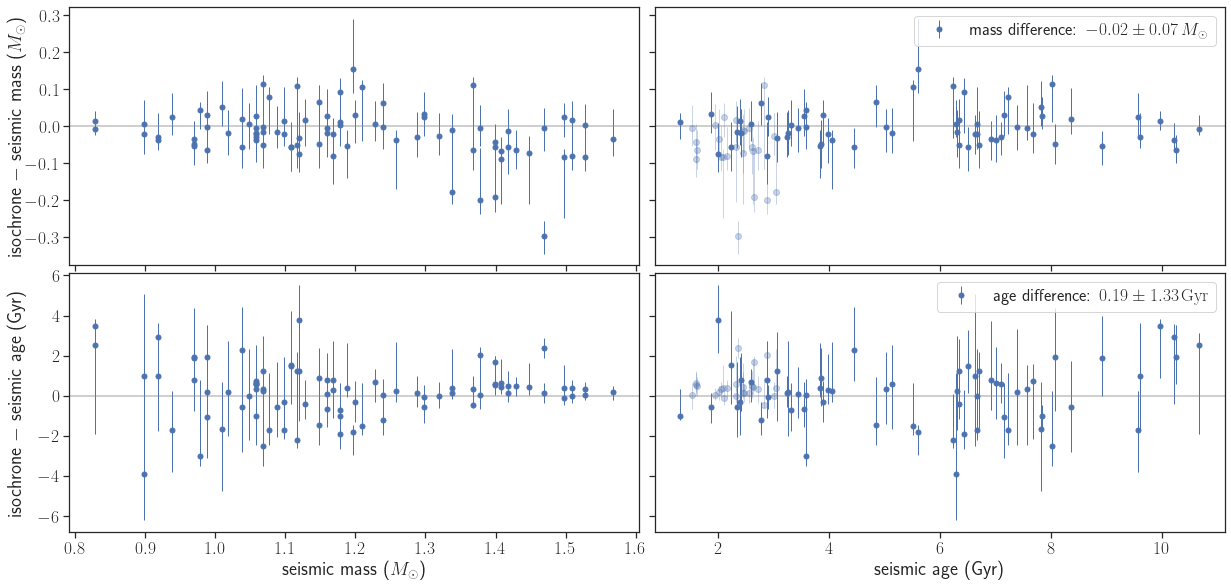

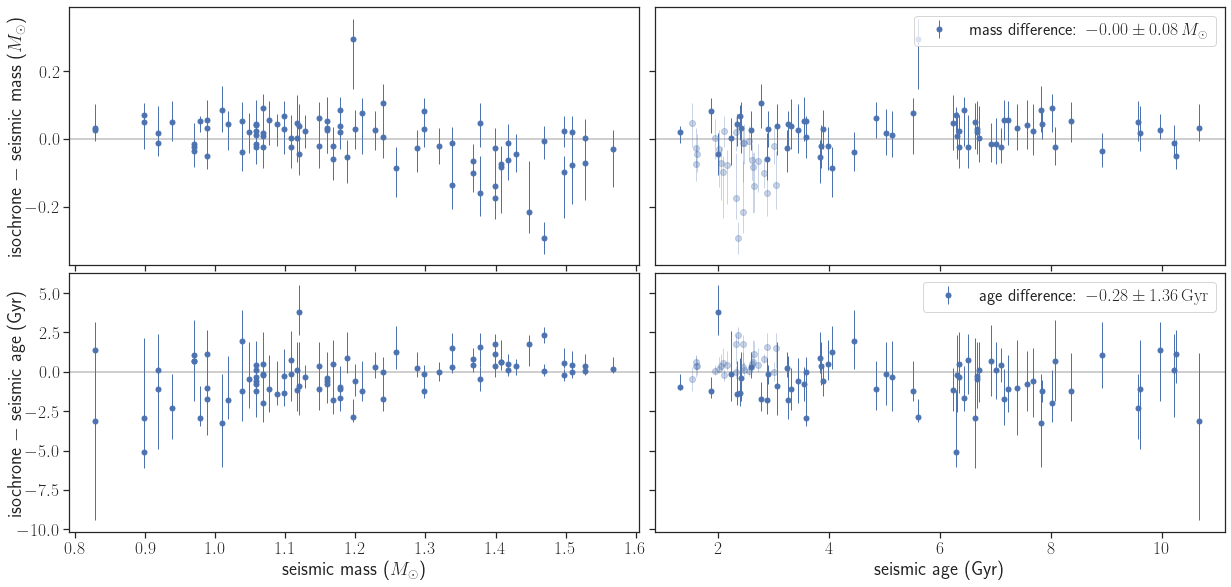

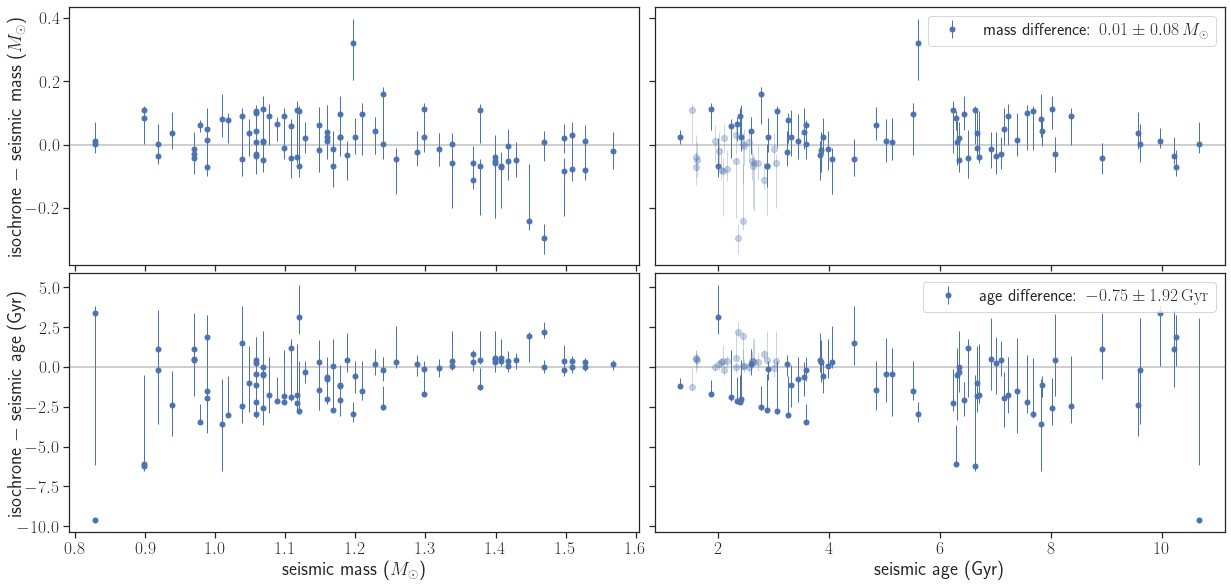

In [35]:
mth = 1.3
for d,l in zip(data, labels):
    idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4)
    figname = l+("_mth%.1f"%mth).replace(".", 'p')
    print (l)
    plot(d, figname)

pct_lin
hdi_lin
pct_log
hdi_log


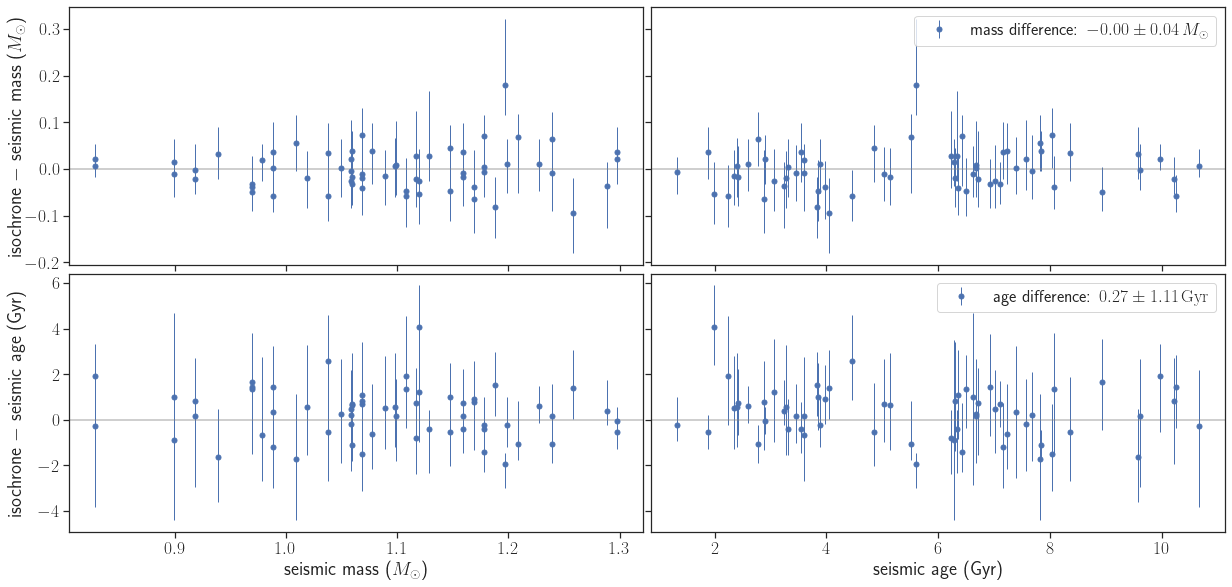

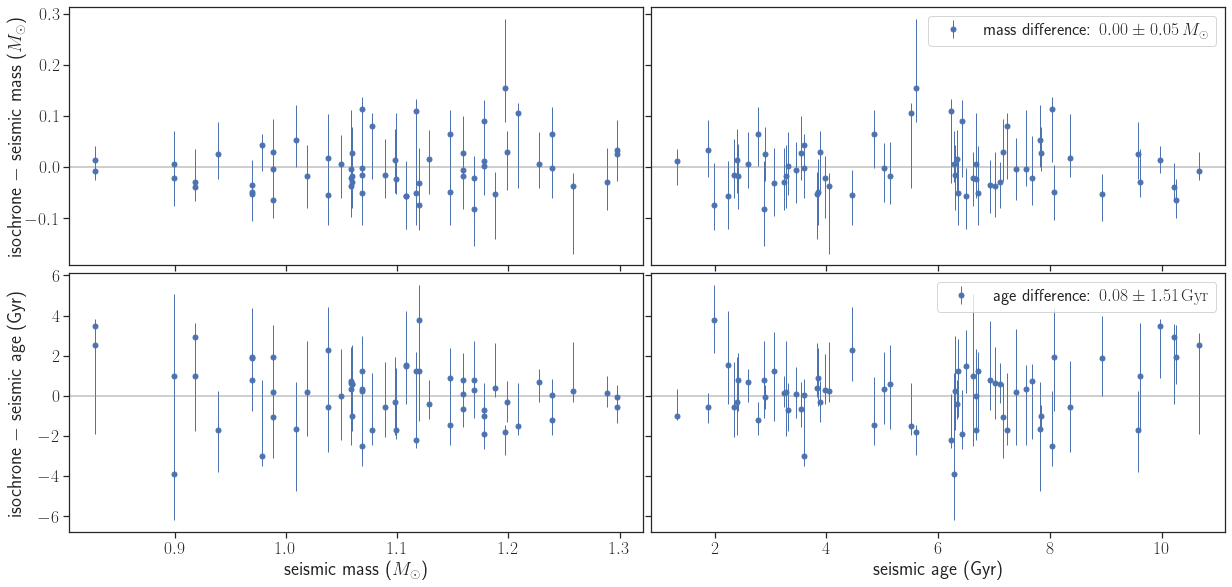

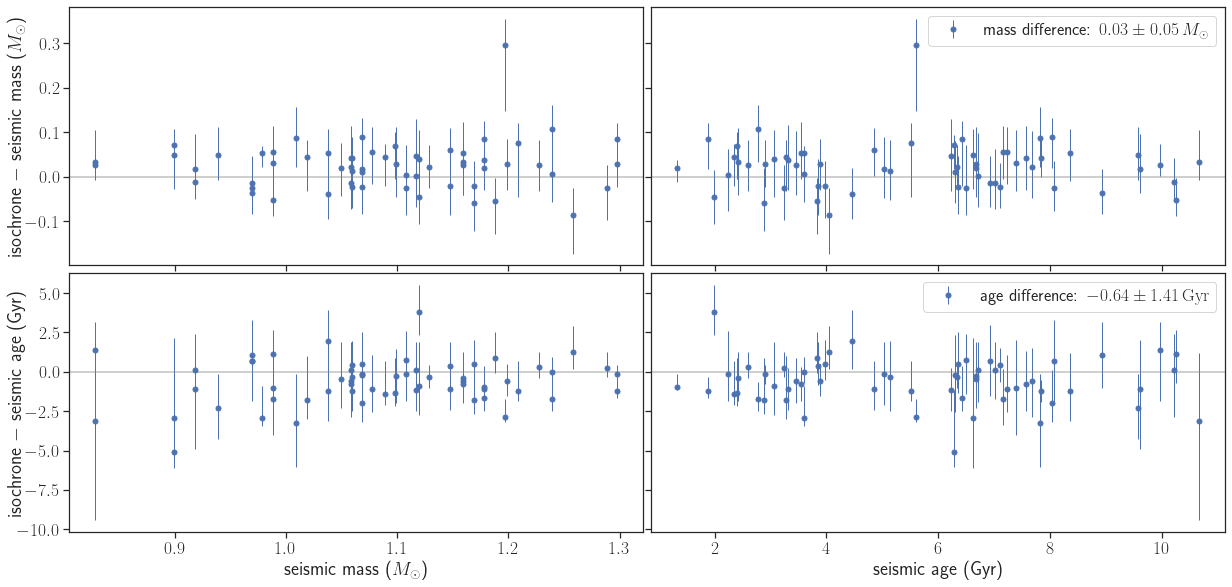

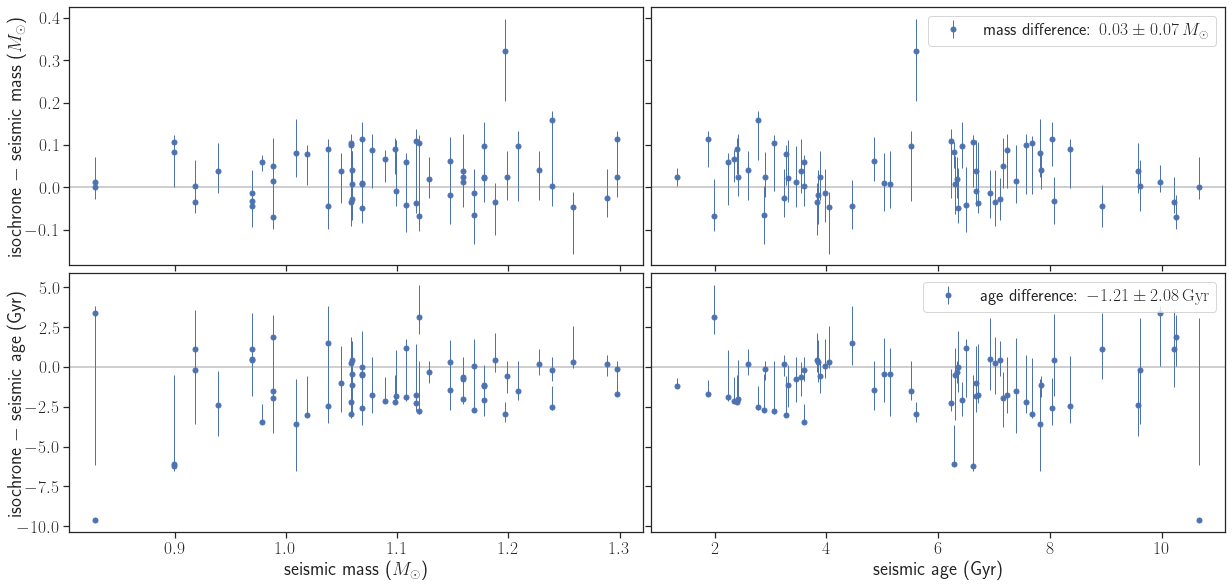

In [36]:
mth = 1.3
for d,l in zip(data, labels):
    idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4) & (d.Mass<mth)
    figname = "mcut_" + l
    print(l)
    plot(d, figname)

pct_lin
hdi_lin
pct_log
hdi_log


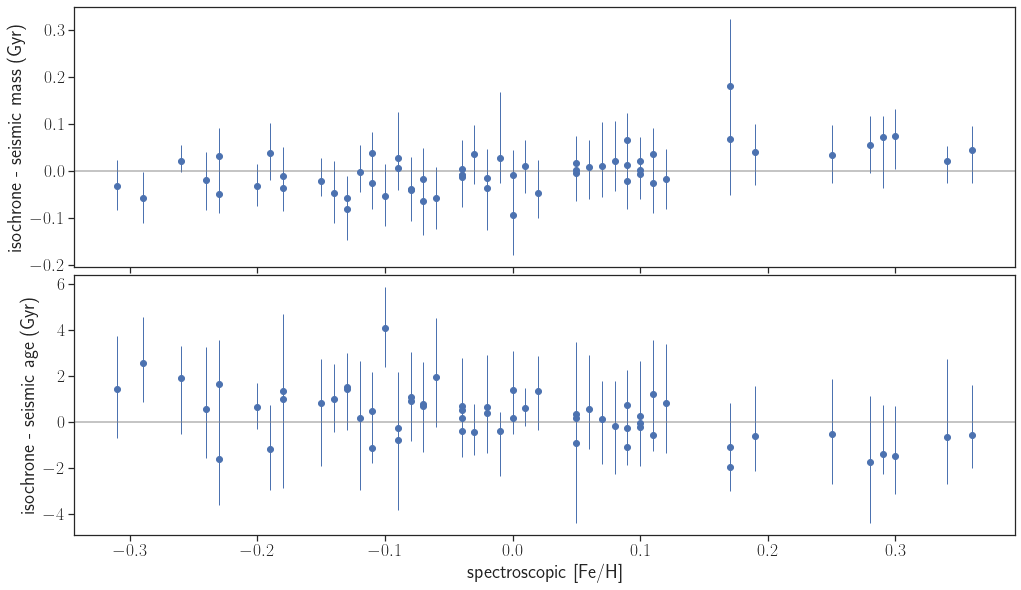

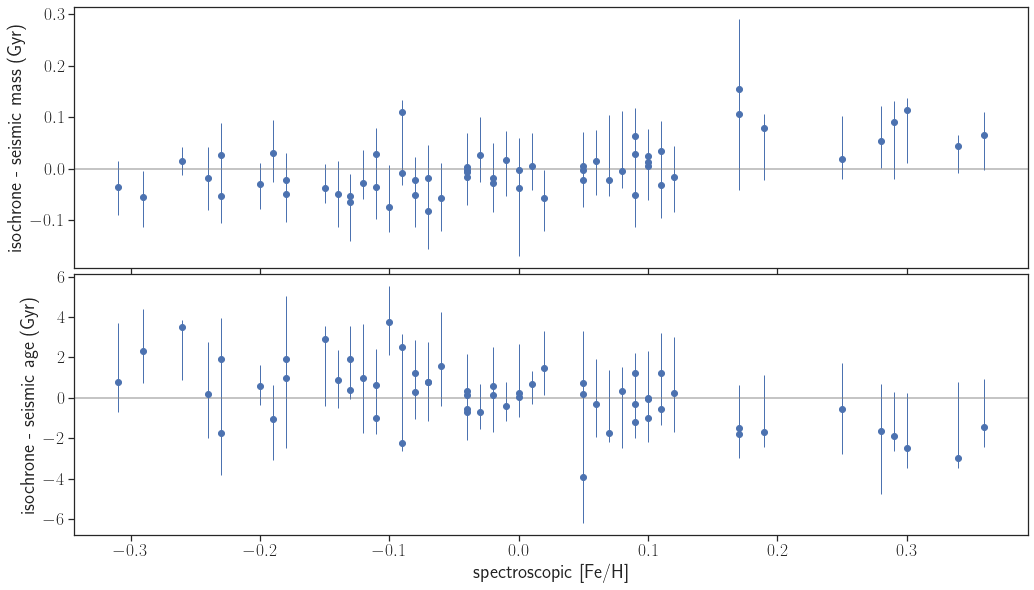

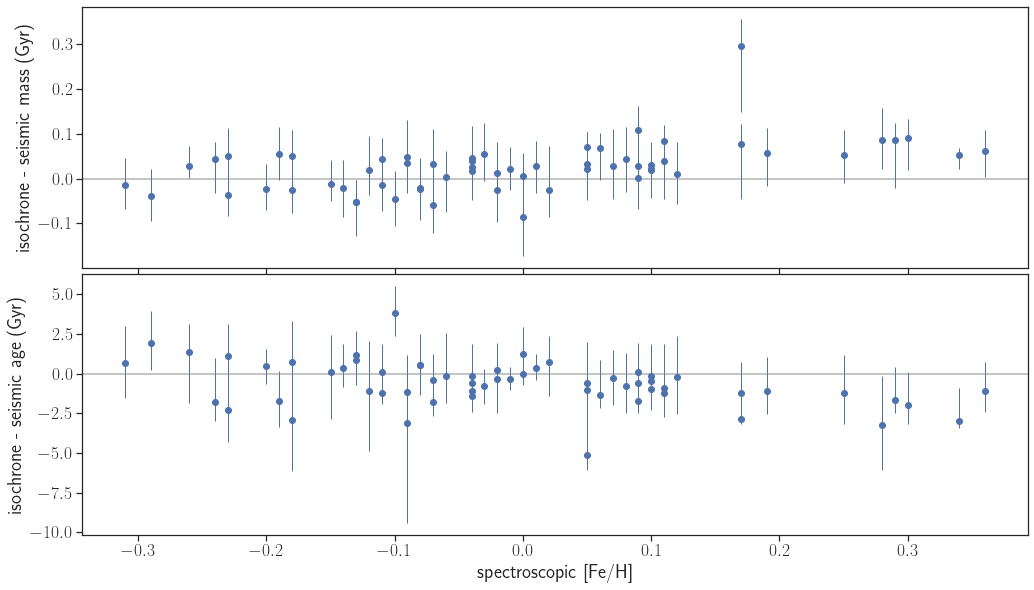

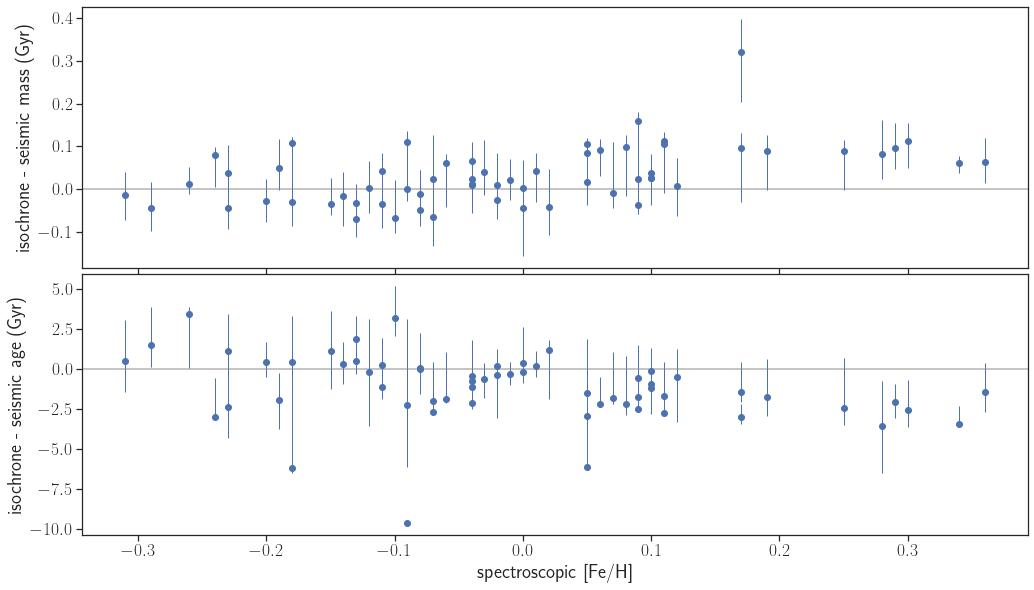

In [37]:
mth = 1.3
for d,l in zip(data, labels):
    print (l)
    
    figname = "feh_mcut_" + l

    idx = (np.abs(d.dsigmateff)<2.) & (np.abs(d.feh)<0.4) & (d.Mass<mth)

    fig, ax = plt.subplots(2, 1, figsize=(14,8), sharex=True)
    ax[1].set_ylabel("isochrone - seismic age (Gyr)")
    #plt.xlabel("spectroscopic [Fe/H]")
    ax[1].errorbar(d[idx].feh, d[idx].iso_age - d[idx].Age, fmt='o', yerr=[d[idx].iso_age_low, d[idx].iso_age_upp], lw=1);
    ax[1].set_xlabel("spectroscopic [Fe/H]")
    ax[1].axhline(y=0, color='gray', alpha=0.6)

    #plt.figure(figsize=(14,7))
    ax[0].set_ylabel("isochrone - seismic mass (Gyr)")
    ax[0].errorbar(d[idx].feh, d[idx].iso_mass - d[idx].Mass, fmt='o', yerr=[d[idx].iso_mass_low, d[idx].iso_mass_upp], lw=1)
    ax[0].axhline(y=0, color='gray', alpha=0.6)

    plt.tight_layout(pad=0.02)
    plt.savefig(figname, dpi=200, bbox_inches="tight")